In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

In [5]:
f = open("data/xgb_tuning_train_data.pkl", 'r')
lines = f.readlines()
nCnt = 0
for line in lines:
    try:
        print(line)
    except KeyError:
        print(nCnt)
    
    nCnt = nCnt + 1
    
f.close()

UnicodeDecodeError: 'cp949' codec can't decode byte 0x80 in position 0: illegal multibyte sequence

In [3]:
df1 = pd.read_pickle('data/xgb_tuning_train_data (1).pkl')
df1.head()

KeyError: 0

In [42]:
df = pd.read_pickle('data/train_set_KDU.pkl')
df.head()

,prices,Open,High,Low,Close,compound,neg,neu,pos
2007-01-01,12469,12475.916211,12558.621875,12423.344141,12469.971875,-0.9851,0.160,0.738,0.102
2007-01-02,12472,12467.728125,12569.485742,12414.082227,12472.245703,0.4395,0.117,0.775,0.109
2007-01-03,12474,12459.540039,12580.349609,12404.820313,12474.519531,-0.9995,0.192,0.748,0.060
2007-01-04,12480,12473.160156,12510.410156,12403.860352,12480.690430,-0.9973,0.113,0.827,0.060
2007-01-05,12398,12480.049805,12480.129883,12365.410156,12398.009766,0.9726,0.082,0.829,0.089


In [43]:
train_end = '2014-12-31'
test_start = '2015-01-01'
train_x = df.loc[:train_end]
test_x = df.loc[test_start:]
train_y = train_x.prices
test_y = test_x.prices
train_x = train_x.drop('prices', axis='columns')
test_x = test_x.drop('prices', axis='columns')

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train_x, train_y)

C:\Users\kduar_000\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### GradientBoostingRegressor 적용

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(train_x, train_y)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))

0.9999458606644067
0.7276102894846126


In [46]:
pred = rf.predict(test_x)
pred_df = pd.DataFrame(data=pred, index=test_x.index, columns=['pred_prices'])
pred_df.head()

,pred_prices
2015-01-01,17864.8
2015-01-02,17851.7
2015-01-03,17754.8
2015-01-04,17625.7
2015-01-05,17529.2


In [47]:
pred_model = model.predict(test_x)
pred_dfM = pd.DataFrame(data=pred_model, index=test_x.index, columns=['pred_prices'])
pred_dfM.head()

,pred_prices
2015-01-01,17828.473541
2015-01-02,17827.568334
2015-01-03,17739.377640
2015-01-04,17653.825412
2015-01-05,17477.717899


In [48]:
r2_score(test_y, pred_df)

0.7313801817413625

In [49]:
r2_score(test_y, pred_dfM)

0.7276102894846126

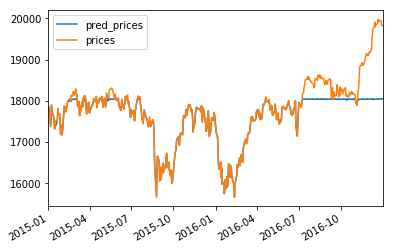

In [50]:
ax = pred_df.plot()
fig = pd.DataFrame(test_y).plot(ax=ax)

In [52]:
train_pred = rf.predict(train_x)
train_pred = pd.Series(train_pred, index=train_x.index)

In [53]:
len(train_x)

2921

In [54]:
days = 5
day_int = np.arange(days, len(train_x)-days, days)
total_days=0
mean_diff = 0
for day in day_int:
    act_mean = train_y[(day-days):day].mean()
    pred_mean = train_pred[day:(day+days)].mean()
    mean_diff += (pred_mean-act_mean)
    total_days += 1
mean_diff = mean_diff / total_days
mean_diff

9.574648370497387

60일에서 5일로 구간을 줄였더니 더 좋아졌다

In [55]:
# 지수 이동평균 구하기
# 60일의 지수 이동평균을 구하기
#pred_df['ewm_prices'] = pred_df.ewm(span=60).mean() + mean_diff
pred_df['ewm_prices'] = pred_df.ewm(span=5).mean() + mean_diff
pred_df.head()

,pred_prices,ewm_prices
2015-01-01,17864.8,17874.374648
2015-01-02,17851.7,17866.514648
2015-01-03,17754.8,17818.132543
2015-01-04,17625.7,17742.176187
2015-01-05,17529.2,17664.093132


In [56]:
pred_dfM['ewm_prices'] = pred_dfM.ewm(span=5).mean() + mean_diff
pred_dfM.head()

,pred_prices,ewm_prices
2015-01-01,17828.473541,17838.048190
2015-01-02,17827.568334,17837.505065
2015-01-03,17739.377640,17795.559013
2015-01-04,17653.825412,17740.662217
2015-01-05,17477.717899,17643.397083


### (비교) GradientBoostingRegressor 적용 하였으나 RandomForestRegressor 보다 성능이 좋지 않았다. 

In [57]:
r2_score(test_y, pred_df.ewm_prices)

0.7194646589850312

In [58]:
r2_score(test_y, pred_dfM.ewm_prices)

0.7166274516547816

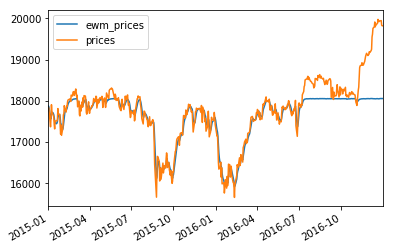

In [59]:
ax = pred_df[['ewm_prices']].plot()
fig = pd.DataFrame(test_y).plot(ax=ax)